In [1]:
# Instalar librerias
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Definir rutas de directorios de datos
train_dir = './DATA/TRAIN'
val_dir = './DATA/VAL'
test_dir = './DATA/TEST'

In [3]:
# Dimensiones de las imágenes
img_width, img_height = 224, 224

In [4]:
# Configurar el preprocesamiento de imágenes y generadores de datos
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

Found 4020 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 39 images belonging to 3 classes.


In [5]:
# Definir modelo
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [6]:
# Compilar modelo
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [7]:
# Graficar modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

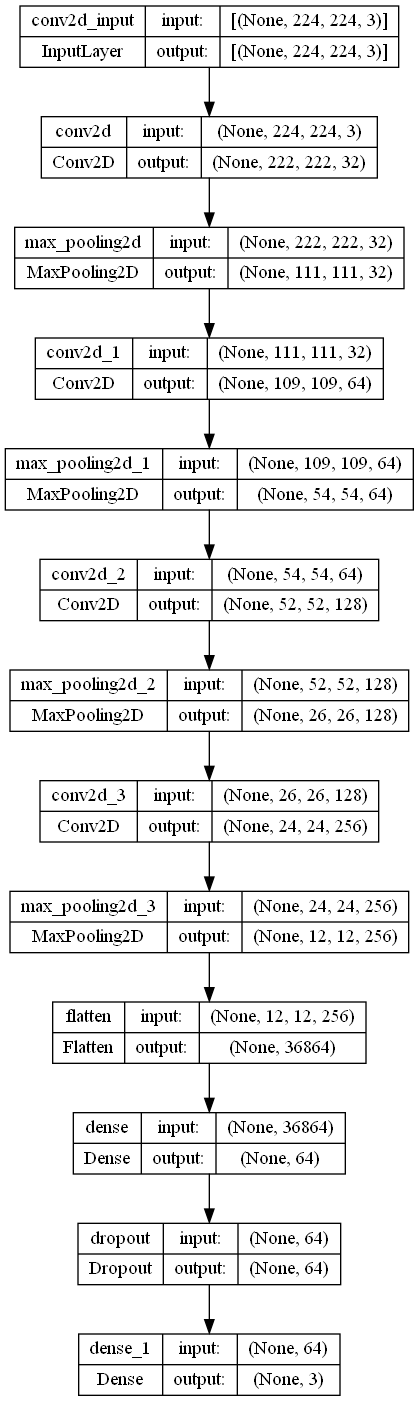

In [8]:
from keras.utils.vis_utils import plot_model

# Graficar modelo
plot_model(model, to_file='CNN4.png', show_shapes=True)

In [ ]:
# Crear lista de nodos
nodes = []
for i, layer in enumerate(model.layers):
    layer_name = layer.__class__.__name__
    nodes.append((i, layer_name))

# Crear lista de aristas
edges = []
for i, layer in enumerate(model.layers[:-1]):
    edges.append((i, i+1))

# Crear figura y dibujar grafo
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

for node in nodes:
    ax.text(node[0], 0.5, node[1], fontsize=14, ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.9))

for edge in edges:
    ax.annotate("", xytext=(edge[0], 0.5), xy=(edge[1], 0.5), arrowprops=dict(arrowstyle='->', color='gray', alpha=0.6))

ax.set_axis_off()
plt.show()

In [ ]:
# Definir callbacks
early_stop = EarlyStopping(patience=5)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

In [ ]:
# Entrenar modelo
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        callbacks=[early_stop, checkpoint])

In [ ]:
# Graficar la curva de pérdida
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

# Graficar la curva de precisión
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Curva de precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.show()

In [ ]:
# Graficar resultados de entrenamiento y evaluación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Evaluar modelo con conjunto de prueba
model.load_weights('best_model.h5')
test_loss, test_acc = model.evaluate_generator(test_generator)
print('Test accuracy:', test_acc)

In [ ]:
import sklearn.metrics as metrics
from metrics import classification_report

# Cargar los pesos del modelo
model.load_weights('best_model.h5')

# Obtener las predicciones del modelo en el conjunto de prueba
predictions = model.predict_generator(test_generator)

# Obtener las etiquetas verdaderas del conjunto de prueba
true_labels = test_generator.classes

# Obtener el reporte de clasificación para cada clase
report = classification_report(true_labels, np.argmax(predictions, axis=1), target_names=test_generator.class_indices.keys(), output_dict=True)

# Crear una figura de barras para la precisión, recuperación y puntuación F1
fig, ax = plt.subplots(figsize=(8, 5))
ind = np.arange(len(report.keys())-3)
width = 0.25

for i, metric in enumerate(['precision', 'recall', 'f1-score']):
    scores = [report[label][metric] for label in test_generator.class_indices.keys()]
    ax.bar(ind+i*width, scores, width, label=metric)

ax.set_xticks(ind + width)
ax.set_xticklabels(test_generator.class_indices.keys())
ax.set_ylim([0, 1.0])
ax.set_xlabel('Clases')
ax.set_ylabel('Valor')
ax.legend()

plt.show()

In [ ]:
# Función para predecir una imagen
def classify_image(image_path):
    img = load_img(image_path, target_size=(img_width, img_height))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    prediction = model.predict(x)[0]

    classes = ['Normal', 'Neumonia_Bacteria', 'Neumonia_Virus']
    for i in range(len(classes)):
        print(f'{classes[i]}: {prediction[i] * 100:.2f}%')

    predicted_class = np.argmax(prediction)

    return classes[predicted_class]

In [ ]:
def classify_image(image_path):
    img = load_img(image_path, target_size=(img_width, img_height))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    prediction = model.predict(x)[0]

    classes = ['Normal', 'Neumonia_Bacteria', 'Neumonia_Virus']
    predicted_class = np.argmax(prediction)

    # Crear dos subplots: uno para la imagen y otro para las probabilidades
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Mostrar la imagen en el primer subplot
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title('Imagen')

    # Crear una lista de colores para las barras de las probabilidades
    colors = ['g' if i == predicted_class else 'r' for i in range(len(classes))]

    # Mostrar las probabilidades en un gráfico de barras horizontal en el segundo subplot
    ax2.barh(classes, prediction * 100, color=colors)
    ax2.set_xlim([0, 100])
    ax2.set_title('Probabilidades')
    ax2.set_xlabel('%')

    # Ajustar los subplots y mostrar la figura
    plt.tight_layout()
    plt.show()

    return classes[predicted_class]
